# Efficient Net model

Build and train model that takes spectrogram as input and is based on pretrained EfficientNet architecture.

## Import libraries and set hyperparameters

In [1]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from tqdm import tqdm

In [2]:
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = Path('../Spectograms/')

## Create custom dataset

In [3]:
class BirdSpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.spectrogram_paths = []
        self.labels = []
        self.label_encoder = LabelEncoder()

        # Load spectrogram file paths and labels
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                for file_name in os.listdir(label_dir):
                    if file_name.endswith(".png"):
                        self.spectrogram_paths.append(os.path.join(label_dir, file_name))
                        self.labels.append(label)

        # Encode labels
        self.labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.spectrogram_paths)

    def __getitem__(self, idx):
        spectrogram_path = self.spectrogram_paths[idx]
        label = self.labels[idx]

        try:
            spectrogram = cv2.imread(spectrogram_path, cv2.IMREAD_GRAYSCALE)
            if spectrogram is None:
                print(f"Failed to read spectrogram: {spectrogram_path}")
                return None, None
        except Exception as e:
            print(f"Error reading spectrogram: {spectrogram_path} - {e}")
            return None, None

        spectrogram = cv2.resize(spectrogram, (224, 224))
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0) / 255.0  # Normalize to [0, 1]

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, label

## Create DataLoaders

In [4]:
def custom_collate_fn(batch):
    # Filter out None or invalid samples in the batch
    batch = [sample for sample in batch if sample[0] is not None]
    
    # If no valid samples, return an empty batch
    if len(batch) == 0:
        return None, None

    inputs, labels = zip(*batch)

    inputs = torch.stack(inputs, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return inputs, labels


In [5]:
datasets = {
    phase: BirdSpectrogramDataset(os.path.join(DATA_DIR, phase))
    for phase in ['train', 'val', 'test']
}

data_loaders = {
    phase: DataLoader(datasets[phase], batch_size=BATCH_SIZE, shuffle=(phase == 'train'), collate_fn=custom_collate_fn)
    for phase in ['train', 'val', 'test']
}

data_sizes = {phase: len(datasets[phase]) for phase in ['train', 'val', 'test']}

## Create model

In [6]:
def create_model():
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    
    model.features[0][0] = nn.Conv2d(1, model.features[0][0].out_channels, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(data_loaders['train'].dataset.label_encoder.classes_))
    model = model.to(DEVICE)
    return model

model = create_model()
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

## Implement training and validation

In [8]:
class_labels = np.unique(data_loaders['train'].dataset.labels)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=class_labels, 
    y=data_loaders['train'].dataset.labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
print(class_weights)

tensor([ 0.5291,  2.0938,  3.7827, 20.4304,  2.4609,  1.2621,  1.5734,  7.2658,
         1.5662,  1.9089,  0.9819,  0.3133,  1.8879,  1.5562,  0.8879,  0.4451,
         0.2837,  1.5313,  3.9912,  0.9995], device='cuda:0')


In [9]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=5, min_delta=0.0, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        """
        Saves model when validation loss decreases.
        """
        torch.save(model.state_dict(), self.path)
        print("Validation loss decreased. Saving model...\n")

In [10]:
def train_step(model, data_loader, loss_fn, optimizer, device):
    """
    Perform a single training step on the dataset.
    """
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in tqdm(data_loader, desc="Training"):
        if inputs is None or labels is None:
            continue  # Skip the batch if it's empty after filtering invalid samples
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    
    return epoch_loss, epoch_acc

def val_step(model, data_loader, loss_fn, device):
    """
    Perform a single validation step on the dataset.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.inference_mode():
        for inputs, labels in tqdm(data_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    
    return epoch_loss, epoch_acc

def train_model(model, dataloaders, loss_fn, optimizer, device='cpu', num_epochs=10, patience=5, min_delta=0.0):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    BEST_MODEL_PATH = Path('./efficient_net_model.pth')
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta, path=BEST_MODEL_PATH)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # Training step
        train_loss, train_acc = train_step(model, dataloaders['train'], loss_fn, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc.item())
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Validation step
        val_loss, val_acc = val_step(model, dataloaders['val'], loss_fn, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")

        # Early stopping check
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load the best model after training stops
    model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))

    return {'train_losses': train_losses, 'val_losses': val_losses, 'train_accuracies': train_accuracies, 'val_accuracies': val_accuracies}

In [11]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Train classifier head

In [12]:
# Unfreeze classifier parameters
for param in model.classifier.parameters():
    param.requires_grad = True

In [13]:
head_history = train_model(model, data_loaders, loss_fn, optimizer, device=DEVICE, num_epochs=5)

Epoch 1/5
----------


Training: 100%|██████████| 2580/2580 [18:58<00:00,  2.27it/s]


Train Loss: 2.2177 Acc: 0.4216


Validation:  66%|██████▌   | 194/294 [02:20<01:19,  1.26it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [03:03<00:41,  1.15it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [03:40<00:00,  1.33it/s]


Val Loss: 1.7388 Acc: 0.5045

Validation loss decreased. Saving model...

Epoch 2/5
----------


Training: 100%|██████████| 2580/2580 [17:28<00:00,  2.46it/s]


Train Loss: 2.0026 Acc: 0.4630


Validation:  66%|██████▌   | 194/294 [01:17<00:41,  2.42it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:38<00:19,  2.49it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:57<00:00,  2.49it/s]


Val Loss: 1.6618 Acc: 0.5204

Validation loss decreased. Saving model...

Epoch 3/5
----------


Training: 100%|██████████| 2580/2580 [17:29<00:00,  2.46it/s]


Train Loss: 1.9620 Acc: 0.4712


Validation:  66%|██████▌   | 194/294 [01:17<00:41,  2.42it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:39<00:21,  2.23it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:58<00:00,  2.49it/s]


Val Loss: 1.7230 Acc: 0.5037

Epoch 4/5
----------


Training: 100%|██████████| 2580/2580 [17:41<00:00,  2.43it/s]


Train Loss: 1.9359 Acc: 0.4740


Validation:  66%|██████▌   | 194/294 [01:17<00:41,  2.41it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:38<00:21,  2.26it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:58<00:00,  2.48it/s]


Val Loss: 1.6276 Acc: 0.5312

Validation loss decreased. Saving model...

Epoch 5/5
----------


Training: 100%|██████████| 2580/2580 [17:45<00:00,  2.42it/s]


Train Loss: 1.9366 Acc: 0.4745


Validation:  66%|██████▌   | 194/294 [01:21<00:42,  2.34it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:43<00:19,  2.47it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [02:01<00:00,  2.41it/s]


Val Loss: 1.6343 Acc: 0.5332



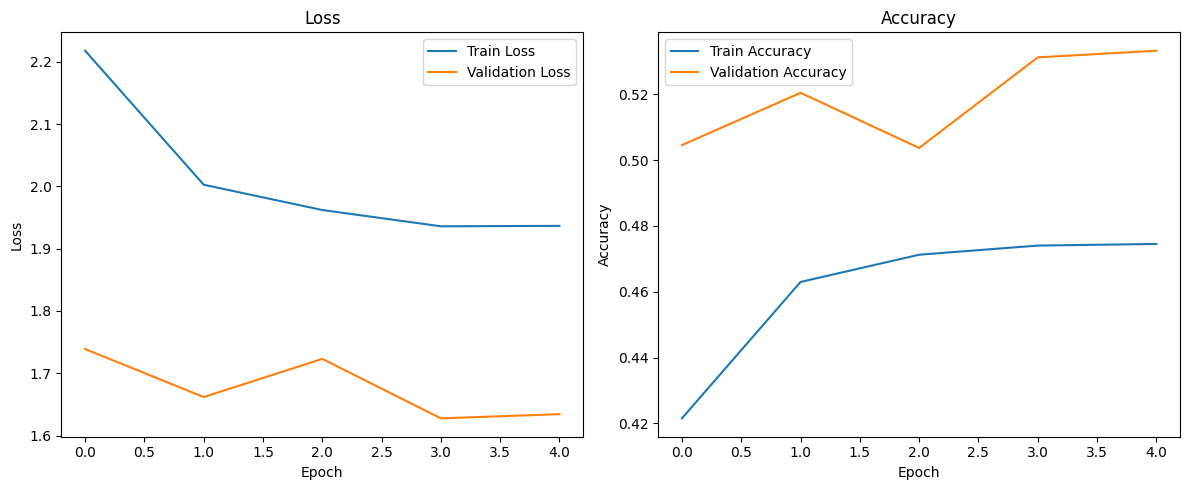

In [14]:
plot_training(head_history['train_losses'], head_history['val_losses'], head_history['train_accuracies'], head_history['val_accuracies'])

## Save and load model

In [15]:
HEAD_MODEL_PATH = './head_model.pth'
torch.save(model.state_dict(), HEAD_MODEL_PATH)

In [16]:
model = create_model()
model.load_state_dict(torch.load(HEAD_MODEL_PATH, map_location=DEVICE))

C:\Users\micha\AppData\Local\Temp\ipykernel_13096\945429107.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(HEAD_MODEL_PATH, map_locatio

<All keys matched successfully>

## Unfreeze and fine tune

In [17]:
for param in model.parameters():
    param.requires_grad = True

# Redefine optimizer for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE / 10)

# Fine-tune the entire model
full_history = train_model(model, data_loaders, loss_fn, optimizer, device=DEVICE, num_epochs=EPOCHS)

Epoch 1/50
----------


Training: 100%|██████████| 2580/2580 [28:41<00:00,  1.50it/s]


Train Loss: 1.0428 Acc: 0.7253


Validation:  66%|██████▌   | 194/294 [01:23<00:48,  2.06it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:47<00:20,  2.33it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [02:06<00:00,  2.33it/s]


Val Loss: 0.6261 Acc: 0.8143

Validation loss decreased. Saving model...

Epoch 2/50
----------


Training: 100%|██████████| 2580/2580 [28:34<00:00,  1.50it/s]


Train Loss: 0.5905 Acc: 0.8377


Validation:  66%|██████▌   | 194/294 [01:20<00:42,  2.35it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:42<00:20,  2.36it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [02:01<00:00,  2.42it/s]


Val Loss: 0.5944 Acc: 0.8300

Validation loss decreased. Saving model...

Epoch 3/50
----------


Training: 100%|██████████| 2580/2580 [28:23<00:00,  1.51it/s]


Train Loss: 0.4251 Acc: 0.8764


Validation:  66%|██████▌   | 194/294 [01:21<00:42,  2.34it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:42<00:19,  2.45it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [02:01<00:00,  2.41it/s]


Val Loss: 0.5167 Acc: 0.8556

Validation loss decreased. Saving model...

Epoch 4/50
----------


Training: 100%|██████████| 2580/2580 [28:09<00:00,  1.53it/s]


Train Loss: 0.3177 Acc: 0.9030


Validation:  66%|██████▌   | 194/294 [01:19<00:41,  2.39it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:40<00:19,  2.47it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:59<00:00,  2.46it/s]


Val Loss: 0.4678 Acc: 0.8749

Validation loss decreased. Saving model...

Epoch 5/50
----------


Training: 100%|██████████| 2580/2580 [28:09<00:00,  1.53it/s]


Train Loss: 0.2366 Acc: 0.9216


Validation:  66%|██████▌   | 194/294 [01:19<00:41,  2.41it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:40<00:19,  2.49it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:58<00:00,  2.47it/s]


Val Loss: 0.4358 Acc: 0.8862

Validation loss decreased. Saving model...

Epoch 6/50
----------


Training: 100%|██████████| 2580/2580 [27:43<00:00,  1.55it/s]


Train Loss: 0.1879 Acc: 0.9356


Validation:  66%|██████▌   | 194/294 [01:19<00:41,  2.42it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:40<00:19,  2.44it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:59<00:00,  2.46it/s]


Val Loss: 0.4570 Acc: 0.8831

Epoch 7/50
----------


Training: 100%|██████████| 2580/2580 [28:23<00:00,  1.51it/s]


Train Loss: 0.1501 Acc: 0.9464


Validation:  66%|██████▌   | 194/294 [01:22<00:42,  2.35it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:44<00:19,  2.41it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [02:02<00:00,  2.39it/s]


Val Loss: 0.4669 Acc: 0.8832

Epoch 8/50
----------


Training: 100%|██████████| 2580/2580 [28:18<00:00,  1.52it/s]


Train Loss: 0.1215 Acc: 0.9537


Validation:  66%|██████▌   | 194/294 [01:19<00:41,  2.41it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:40<00:19,  2.50it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:59<00:00,  2.45it/s]


Val Loss: 0.4641 Acc: 0.8940

Epoch 9/50
----------


Training: 100%|██████████| 2580/2580 [27:54<00:00,  1.54it/s]


Train Loss: 0.1061 Acc: 0.9594


Validation:  66%|██████▌   | 194/294 [01:19<00:42,  2.35it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:40<00:19,  2.47it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:59<00:00,  2.47it/s]


Val Loss: 0.4928 Acc: 0.8859

Epoch 10/50
----------


Training: 100%|██████████| 2580/2580 [27:48<00:00,  1.55it/s]


Train Loss: 0.0898 Acc: 0.9651


Validation:  66%|██████▌   | 194/294 [01:17<00:40,  2.44it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia luscinia\831189_part242.png


Validation:  84%|████████▎ | 246/294 [01:38<00:19,  2.48it/s]

Failed to read spectrogram: ..\Spectograms\val\Luscinia megarhynchos\653823_part94.png


Validation: 100%|██████████| 294/294 [01:57<00:00,  2.51it/s]


Val Loss: 0.5297 Acc: 0.8901

Early stopping triggered


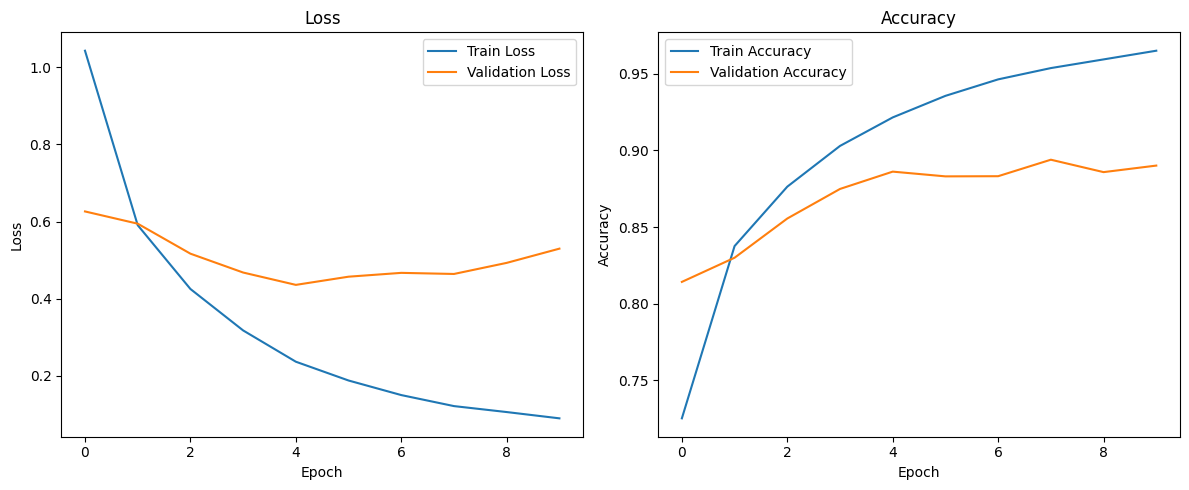

In [18]:
plot_training(full_history['train_losses'], full_history['val_losses'], full_history['train_accuracies'], full_history['val_accuracies'])

## Test model

In [19]:
def evaluate_model(model, test_dataloader, device='cpu'):
    model.eval()

    true_labels = []
    pred_labels = []

    running_loss = 0.0
    running_corrects = 0
    criterion = nn.CrossEntropyLoss()

    with torch.inference_mode():
        for inputs, labels in tqdm(test_dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            preds = torch.argmax(outputs, dim=1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            true_labels.extend(labels.data.cpu().tolist())
            pred_labels.extend(preds.cpu().tolist())

    avg_loss = running_loss / len(test_dataloader.dataset)
    accuracy = running_corrects.double() / len(test_dataloader.dataset)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return true_labels, pred_labels

In [20]:
true_labels, pred_labels = evaluate_model(model, data_loaders['test'], device=DEVICE)

Evaluating: 100%|██████████| 298/298 [01:59<00:00,  2.50it/s]

Test Loss: 0.5169
Test Accuracy: 86.58%


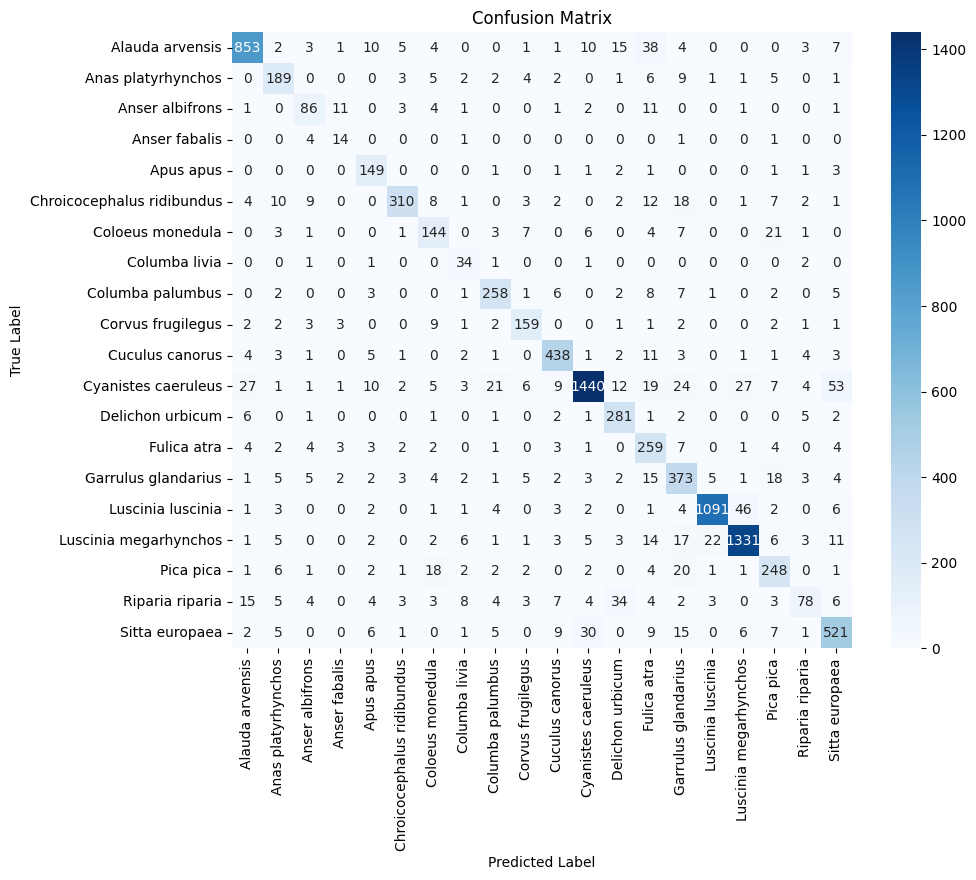

In [21]:
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
class_names = data_loaders['test'].dataset.label_encoder.classes_

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print(classification_report(true_labels, pred_labels, target_names=data_loaders['test'].dataset.label_encoder.classes_))

                            precision    recall  f1-score   support

           Alauda arvensis       0.93      0.89      0.91       957
        Anas platyrhynchos       0.78      0.82      0.80       231
           Anser albifrons       0.69      0.70      0.70       122
             Anser fabalis       0.40      0.67      0.50        21
                 Apus apus       0.75      0.93      0.83       160
Chroicocephalus ridibundus       0.93      0.79      0.86       390
          Coloeus monedula       0.69      0.73      0.71       198
             Columba livia       0.52      0.85      0.64        40
          Columba palumbus       0.84      0.87      0.85       296
         Corvus frugilegus       0.83      0.84      0.83       189
           Cuculus canorus       0.90      0.91      0.90       481
       Cyanistes caeruleus       0.95      0.86      0.91      1672
          Delichon urbicum       0.79      0.93      0.85       303
               Fulica atra       0.62      0.86

## Manual testing

True Label: Luscinia megarhynchos
Predicted Label: Luscinia megarhynchos



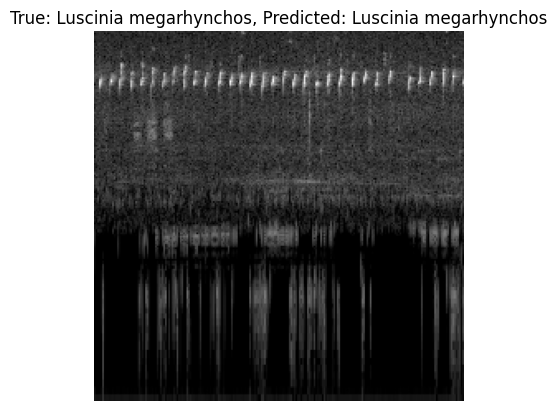

True Label: Anser albifrons
Predicted Label: Anser albifrons



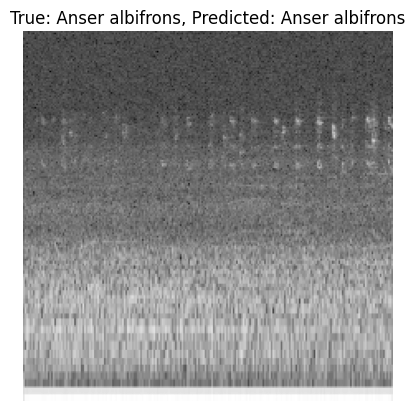

True Label: Delichon urbicum
Predicted Label: Delichon urbicum



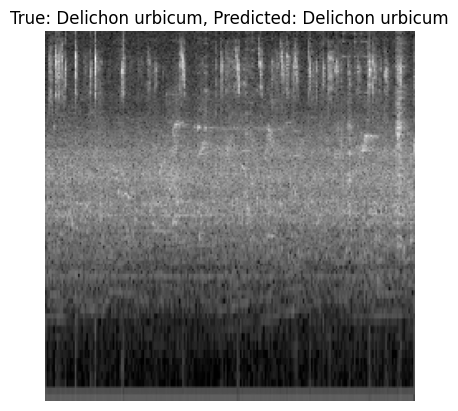

True Label: Alauda arvensis
Predicted Label: Alauda arvensis



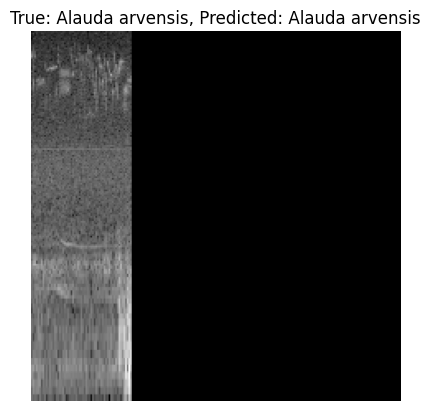

True Label: Chroicocephalus ridibundus
Predicted Label: Chroicocephalus ridibundus



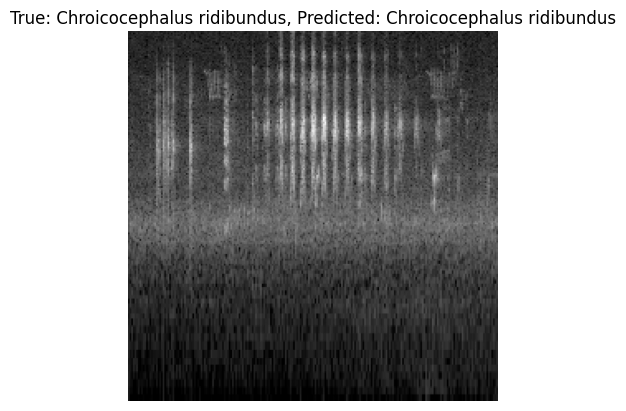

In [23]:
model.eval()

random_indices = random.sample(range(len(datasets['test'])), 5)

for idx in random_indices:
    spectrogram, label = datasets['test'][idx]

    input_tensor = spectrogram.unsqueeze(0).to(DEVICE)  # Add batch dimension
    label_name = datasets['test'].label_encoder.inverse_transform([label])[0]

    with torch.inference_mode():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()
        predicted_label_name = datasets['test'].label_encoder.inverse_transform([prediction])[0]

    print(f"True Label: {label_name}")
    print(f"Predicted Label: {predicted_label_name}\n")

    # Display the spectrogram
    spectrogram_image = spectrogram.squeeze().cpu().numpy()  # Remove channel dimension
    plt.imshow(spectrogram_image, cmap="gray")
    plt.title(f"True: {label_name}, Predicted: {predicted_label_name}")
    plt.axis("off")
    plt.show()